Reference: https://becominghuman.ai/local-binary-pattern-features-for-texture-classification-d0dfd86ebf29

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
!unzip /content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset.zip -d /content/cedar_dataset

Archive:  /content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset.zip
   creating: /content/cedar_dataset/full_org/
  inflating: /content/cedar_dataset/full_org/original_29_18.png  
  inflating: /content/cedar_dataset/full_org/original_2_6.png  
  inflating: /content/cedar_dataset/full_org/original_27_21.png  
  inflating: /content/cedar_dataset/full_org/original_29_24.png  
  inflating: /content/cedar_dataset/full_org/original_20_14.png  
  inflating: /content/cedar_dataset/full_org/original_54_18.png  
  inflating: /content/cedar_dataset/full_org/original_52_1.png  
  inflating: /content/cedar_dataset/full_org/original_17_1.png  
  inflating: /content/cedar_dataset/full_org/original_22_8.png  
  inflating: /content/cedar_dataset/full_org/original_53_11.png  
  inflating: /content/cedar_dataset/full_org/original_31_2.png  
  inflating: /content/cedar_dataset/full_org/original_54_24.png  
  inflating: /content/cedar_dataset/full_org/original_37_24.png  
  inflating: /content/ce

In [ ]:
!ls

cedar_dataset  drive  sample_data


In [ ]:
!ls cedar_dataset

full_forg  full_org  __MACOSX  Readme.txt


In [ ]:
!ls cedar_dataset/full_forg

forgeries_10_10.png  forgeries_26_22.png  forgeries_43_11.png
forgeries_10_11.png  forgeries_26_23.png  forgeries_43_12.png
forgeries_10_12.png  forgeries_26_24.png  forgeries_43_13.png
forgeries_10_13.png  forgeries_26_2.png   forgeries_43_14.png
forgeries_10_14.png  forgeries_26_3.png   forgeries_43_15.png
forgeries_10_15.png  forgeries_26_4.png   forgeries_43_16.png
forgeries_10_16.png  forgeries_26_5.png   forgeries_43_17.png
forgeries_10_17.png  forgeries_26_6.png   forgeries_43_18.png
forgeries_10_18.png  forgeries_26_7.png   forgeries_43_19.png
forgeries_10_19.png  forgeries_26_8.png   forgeries_43_1.png
forgeries_10_1.png   forgeries_26_9.png   forgeries_43_20.png
forgeries_10_20.png  forgeries_2_6.png	  forgeries_43_21.png
forgeries_10_21.png  forgeries_27_10.png  forgeries_43_22.png
forgeries_10_22.png  forgeries_27_11.png  forgeries_43_23.png
forgeries_10_23.png  forgeries_27_12.png  forgeries_43_24.png
forgeries_10_24.png  forgeries_27_13.png  forgeries_43_2.png
forgeries_1

In [ ]:
def extract_signers():
    X_train, X_test, y_train, y_test = [],[],[],[]

    for file_path in os.listdir("cedar_dataset/full_org"):
      if len(file_path.split("_")) == 3:
        tag = file_path.split("_")[0]
        id = file_path.split("_")[1]
        sign_no = file_path.split("_")[2].split(".")[0]

        if int(id) <= 20:
          X_train.append(file_path)
          y_train.append(tag)

        elif int(id) <=26:
          X_test.append(file_path)
          y_test.append(tag)

    for file_path in os.listdir("cedar_dataset/full_forg"):
      if len(file_path.split("_")) == 3:
        tag = file_path.split("_")[0]
        id = file_path.split("_")[1]
        sign_no = file_path.split("_")[2].split(".")[0]

        if int(id) <= 20:
          X_train.append(file_path)
          y_train.append(tag)

        elif int(id) <=26:
          X_test.append(file_path)
          y_test.append(tag)


    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = extract_signers()

In [ ]:
len(X_train)

960

In [ ]:
len(X_test)

288

In [ ]:

train_df = pd.DataFrame(zip(X_train, y_train))
train_df.columns = ["filename", "label"]
test_df = pd.DataFrame(zip(X_test, y_test))
test_df.columns = ["filename", "label"]

In [ ]:
train_df

,filename,label
0,original_14_5.png,original
1,original_8_24.png,original
2,original_10_8.png,original
3,original_2_4.png,original
4,original_8_3.png,original
...,...,...
955,forgeries_4_20.png,forgeries
956,forgeries_5_10.png,forgeries
957,forgeries_11_15.png,forgeries
958,forgeries_18_18.png,forgeries


In [ ]:
test_df

,filename,label
0,original_26_22.png,original
1,original_22_24.png,original
2,original_22_20.png,original
3,original_24_23.png,original
4,original_23_21.png,original
...,...,...
283,forgeries_23_2.png,forgeries
284,forgeries_24_7.png,forgeries
285,forgeries_21_5.png,forgeries
286,forgeries_25_12.png,forgeries


In [ ]:
def label_encoding(label):
  if label == "original":
    return 1
  elif label == "forgeries":
    return 0

In [ ]:
def extract_signer_id(file_path):
  return int(file_path.split("_")[1])

In [ ]:
train_df["label"] = train_df["label"].apply(label_encoding)

In [ ]:
train_df

,filename,label
0,original_14_5.png,1
1,original_8_24.png,1
2,original_10_8.png,1
3,original_2_4.png,1
4,original_8_3.png,1
...,...,...
955,forgeries_4_20.png,0
956,forgeries_5_10.png,0
957,forgeries_11_15.png,0
958,forgeries_18_18.png,0


In [ ]:
train_df["signer"] = train_df["filename"]
test_df["signer"] = test_df["filename"]

In [ ]:
train_df["signer"] = train_df["signer"].apply(extract_signer_id)
test_df["signer"] = test_df["signer"].apply(extract_signer_id)

In [ ]:
train_df

,filename,label,signer
0,original_14_5.png,1,14
1,original_8_24.png,1,8
2,original_10_8.png,1,10
3,original_2_4.png,1,2
4,original_8_3.png,1,8
...,...,...,...
955,forgeries_4_20.png,0,4
956,forgeries_5_10.png,0,5
957,forgeries_11_15.png,0,11
958,forgeries_18_18.png,0,18


In [ ]:
test_df

,filename,label,signer
0,original_26_22.png,original,26
1,original_22_24.png,original,22
2,original_22_20.png,original,22
3,original_24_23.png,original,24
4,original_23_21.png,original,23
...,...,...,...
283,forgeries_23_2.png,forgeries,23
284,forgeries_24_7.png,forgeries,24
285,forgeries_21_5.png,forgeries,21
286,forgeries_25_12.png,forgeries,25


In [ ]:
signer_14 = train_df[train_df["signer"]==14]

In [ ]:
signer_18 = train_df[train_df["signer"]==18]

In [ ]:
signer_18

,filename,label,signer
13,original_18_2.png,1,18
28,original_18_12.png,1,18
34,original_18_10.png,1,18
45,original_18_18.png,1,18
69,original_18_13.png,1,18
78,original_18_3.png,1,18
87,original_18_21.png,1,18
94,original_18_23.png,1,18
110,original_18_8.png,1,18
115,original_18_15.png,1,18


In [ ]:
train_df.shape[0] + test_df.shape[0]

1248

In [ ]:
# path = "/content/cedar_dataset/full_forg/"
# filename = "forgeries_10_1.png"
# image = cv2.imread(os.path.join(path, filename))

# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Perform Otsu's thresholding to get the optimal threshold value
# _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Save the binarized image to the output path
# # cv2.imwrite(output_image_path, thresholded_image)


In [ ]:
# cv2_imshow(thresholded_image)

In [ ]:
def preprocess_image(filename):
  if filename.split("_")[0] == "original":
    path = "/content/cedar_dataset/full_org/"

    if not os.path.exists("/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_org/"):
      os.makedirs("/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_org/")
    output_path = "/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_org/"

  elif filename.split("_")[0] == "forgeries":
    path = "/content/cedar_dataset/full_forg/"

    if not os.path.exists("/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_forg/"):
      os.makedirs("/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_forg/")
    output_path = "/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_forg/"

  image = cv2.imread(os.path.join(path, filename))

  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  image = cv2.resize(image, dsize=(600,300))

  # Perform Otsu's thresholding to get the optimal threshold value
  _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # print(image.shape)
  output_image_path = os.path.join(output_path, filename)
  # Save the binarized image to the output path
  cv2.imwrite(output_image_path, thresholded_image)




In [ ]:
#Binarize all images
for filename in train_df["filename"]:
  preprocess_image(filename)


(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)
(300, 600)

In [ ]:
train_df

,filename,label,signer
0,original_14_5.png,1,14
1,original_8_24.png,1,8
2,original_10_8.png,1,10
3,original_2_4.png,1,2
4,original_8_3.png,1,8
...,...,...,...
955,forgeries_4_20.png,0,4
956,forgeries_5_10.png,0,5
957,forgeries_11_15.png,0,11
958,forgeries_18_18.png,0,18


In [ ]:

def get_images(df):
   counter = 0
   class_images = []
   for filename in df["filename"]:
       if filename.split("_")[0] == "original":
           path = "/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_org/"
       elif filename.split("_")[0] == "forgeries":
           path = "/content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset_preprocessed/full_forg/"

       image = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)

      #  print(image.shape)

       class_images.append(image)


   return np.array(class_images)





In [ ]:
signer_18

,filename,label,signer
13,original_18_2.png,1,18
28,original_18_12.png,1,18
34,original_18_10.png,1,18
45,original_18_18.png,1,18
69,original_18_13.png,1,18
78,original_18_3.png,1,18
87,original_18_21.png,1,18
94,original_18_23.png,1,18
110,original_18_8.png,1,18
115,original_18_15.png,1,18


In [ ]:
signer_14_preprocessed= get_images(signer_14)
signer_18_preprocessed= get_images(signer_18)

In [ ]:
signer_14_preprocessed

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [ ]:
signer_18_preprocessed

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [ ]:
signer_14_labels = signer_14["label"]

In [ ]:
signer_18_labels = signer_18["label"]

In [ ]:
len(signer_14_labels)

48

In [ ]:
len(signer_14_preprocessed)

48

In [ ]:
signer_14_preprocessed

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(signer_14_preprocessed, signer_14_labels, test_size=0.3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(signer_18_preprocessed, signer_18_labels, test_size=0.3)

In [ ]:
def extract_lbp(images):
    lbps = []
    for image in tqdm(images):
        lbp = local_binary_pattern(image, P=8, R=1)
        lbps.append(lbp)

    return np.array(lbps)

In [ ]:
X_train_lbp = extract_lbp(X_train)
X_test_lbp = extract_lbp(X_test)

100%|██████████| 15/15 [00:00<00:00, 33.67it/s]


In [ ]:
def create_histograms(images, sub_images_num, bins_per_sub_images):
    all_histograms = []
    for image in tqdm(images):
        grid = np.arange(0, image.shape[1]+1, image.shape[1]//sub_images_num)

        sub_image_histograms = []

        for i in range(1, len(grid)):
            for j in range(1, len(grid)):
                sub_image = image[grid[i-1]:grid[i], grid[j-1]:grid[j]]

                sub_image_histogram = np.histogram(sub_image, bins=bins_per_sub_images)[0]
                sub_image_histograms.append(sub_image_histogram)

        histogram = np.array(sub_image_histograms).flatten()
        all_histograms.append(histogram)

    return np.array(all_histograms)


In [ ]:
X_train_hist = create_histograms(X_train_lbp, sub_images_num=3, bins_per_sub_images=64)
X_test_hist = create_histograms(X_test_lbp, sub_images_num=3, bins_per_sub_images=64)

print('X_train_hist\t', X_train_hist.shape)
print('X_test_hist\t', X_test_hist.shape)

100%|██████████| 15/15 [00:00<00:00, 184.65it/s]

X_train_hist	 (33, 576)
X_test_hist	 (15, 576)


In [ ]:
model_svm = SVC()
model_svm.fit(X_train_hist, y_train)
svm_train_acc = model_svm.score(X_train_hist, y_train)
print('SVM train acc\t:', svm_train_acc)

# Make predictions on the test data
y_pred = model_svm.predict(X_test_hist)

# Calculate accuracy
svm_test_accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", svm_test_accuracy)




SVM train acc	: 0.5757575757575758
SVM Accuracy: 0.3333333333333333


In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed
model_knn.fit(X_train_hist, y_train)


print('KNN train acc\t:', model_knn.score(X_train_hist, y_train))

# Make predictions on the test data
y_pred = model_knn.predict(X_test_hist)

# Calculate accuracy
knn_test_accuracy = accuracy_score(y_test, y_pred)
print("KNN test Accuracy:", knn_test_accuracy)

# print('KNN test acc\t:', model_knn.score(X_test_hist, y_test))

KNN train acc	: 0.9393939393939394
KNN test Accuracy: 0.7333333333333333


In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators) as needed
random_forest.fit(X_train_hist, y_train)

print('Random Forest train acc\t:', random_forest.score(X_train_hist, y_train))

# Make predictions on the test data
y_pred = random_forest.predict(X_test_hist)

# Calculate accuracy
rf_test_accuracy = accuracy_score(y_test, y_pred)
print("Random forest Accuracy:", rf_test_accuracy)

print('Random Forest test acc\t:', random_forest.score(X_test_hist, y_test))


Random Forest train acc	: 1.0
Random forest Accuracy: 1.0
Random Forest test acc	: 1.0


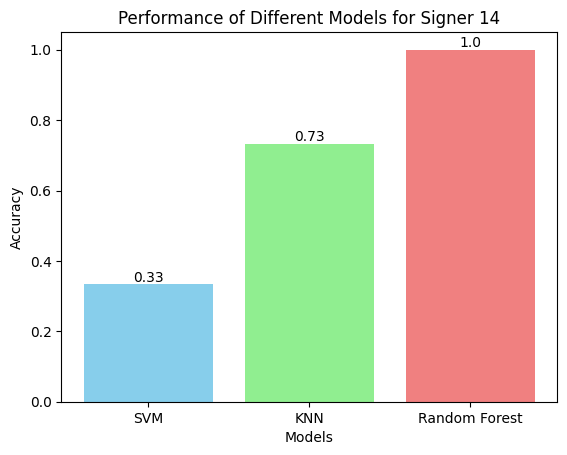

In [ ]:
import matplotlib.pyplot as plt

models = ['SVM', 'KNN', 'Random Forest']
accuracies = [svm_test_accuracy, knn_test_accuracy, rf_test_accuracy]
colors = ['skyblue', 'lightgreen', 'lightcoral']
# Plot the bar chart
plt.bar(models, accuracies , color= colors)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Performance of Different Models for Signer 14')

# Annotate each bar with its value (accuracy)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{round(acc,2)}', ha='center', va='bottom')

# Show the bar chart
plt.show()
